<a href="https://colab.research.google.com/github/parulkohli04/1D_array_solution.c/blob/main/Grass_Weed_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'weedcrop-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2307840%2F3883792%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240827%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240827T192247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ce83d5a2dc181e375336b3f343949e1eae56ceaff721044c0d87a7d4f1bbf6ee505108c17cc96b14f19f4df6c76319993e6838d0fbb30722750811676f7dd0d93191247e55694a2be21a3a7c36fa535f408669bba34b59e9cf7ea09c5f100a315e89199134152cd7c3811bf6c87afb0ff9c1fc4555f71bdb794b2280db4f453a379b41a01c03b3d3b556282dc54e3ece36e87d7ddf90b68aaad23a42abd7f748e87e51cccf74ccd8a7accc9e9bad73472384a92dde2205f29b68acb37125233a12bf90dd6ec9406ddf9a38e7ce8589df07fc897c1e3dc9b35b8f24878e6fd53ae0dd51948616b5d5b39a6bff82e9f7e36899e11a7bb51cde2e94e2090ef9b82,weed-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3851613%2F6675836%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240827%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240827T192247Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93c61156ddda0d5d86bb66fb8d941d68702cc97254247c95597343d06e62d367b4cbfe1ea74c5ea912a9bded044bdd01ea1c6d172c5c322162f39ed2f867ae17b65ed67b0f0412917d2f72f02773daab059cbcb2ce2175262d0d756282e742b413205cd9218308193e6c52e9b6c2212ed4dbb789eda98a5aee9676b3921e5f37ff68fd8489a1adb3aedd86990f8d080b39698d7cb9cda23be883787418a277d34109ce17e9660041888f8cc19cba614d948cd002d09a8811d74e20ca739133edb4cda8c8fa0db55178ef9add4ebeaac691c076967c1b9dfd154132f40029a598bae9875aa61dbe75a7266f87f07b595e041f47307b1f7004cedf357319cfe352'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 263674982 bytes downloaded
Downloaded and uncompressed: weedcrop-image-dataset
[==================================================] 163743041 bytes downloaded
Downloaded and uncompressed: weed-detection
Data source import complete.


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
from sklearn.metrics import classification_report
import time

In [3]:
import os

directory = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/train'
contents = os.listdir(directory)
num_of_dirs = len([name for name in contents if os.path.isdir(os.path.join(directory, name))])

print("Contents of the directory:")
for item in contents:
    print(item)

print(f"\nNumber of directories: {num_of_dirs}")


Contents of the directory:
images
labels

Number of directories: 2


In [4]:
from PIL import Image
import os

# Define the directory path
directory_path = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/train'

# List all files in the directory
file_names = os.listdir(directory_path)

# Load images from the directory
images = []
for file_name in file_names:
    if file_name.endswith('.png') or file_name.endswith('.jpg') or file_name.endswith('.jpeg'):
        image_path = os.path.join(directory_path, file_name)
        image = Image.open(image_path)
        images.append(image)

# Process the images as required
# ...

# Example: Showing the first image
if images:
    images[0].show()
else:
    print("No images found in the directory.")

No images found in the directory.


In [12]:
# Define parameters
batch_size = 128
num_epochs = 2
image_size = (139, 139)
num_classes = 2


In [6]:
# Load the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
class_outputs = Dense(num_classes, activation='softmax')(x)


In [13]:

# Create the model
model = Model(inputs=base_model.input, outputs=class_outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Load the training data with aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_dataset = train_datagen.flow_from_directory(
    '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/train',
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the validation data with moderate data augmentation
val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_dataset = val_datagen.flow_from_directory(
    '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/valid',
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif 10 <= epoch < 20:
        return 0.0001
    else:
        return 0.00001

lr_schedule = LearningRateScheduler(lr_scheduler)

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


# Train the model
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[lr_schedule, early_stop, checkpoint, reduce_lr]
)



Found 2469 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9969 - loss: 0.0380
Epoch 1: val_accuracy improved from -inf to 0.96170, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 0.9969 - loss: 0.0376 - val_accuracy: 0.9617 - val_loss: 0.1881 - learning_rate: 0.0010
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0154
Epoch 2: val_accuracy improved from 0.96170 to 0.98723, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 149s 7s/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.9872 - val_loss: 0.1033 - learning_rate: 0.0010


In [15]:
# Save the model in native Keras format
model.save('plant_disease_model_inception.keras')

import joblib

# Save the model using joblib
joblib.dump(model, 'plant_disease_model_inception.pkl')


['plant_disease_model_inception.pkl']

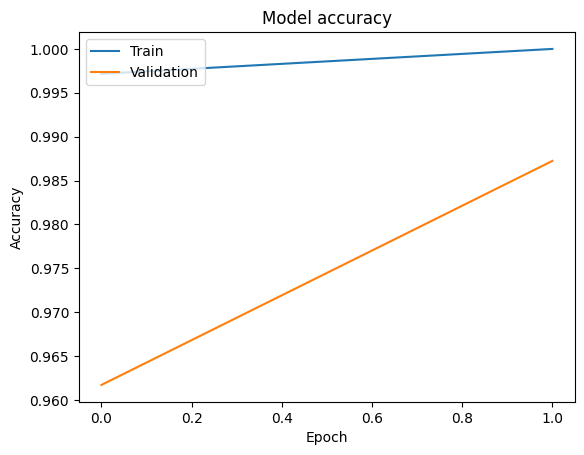

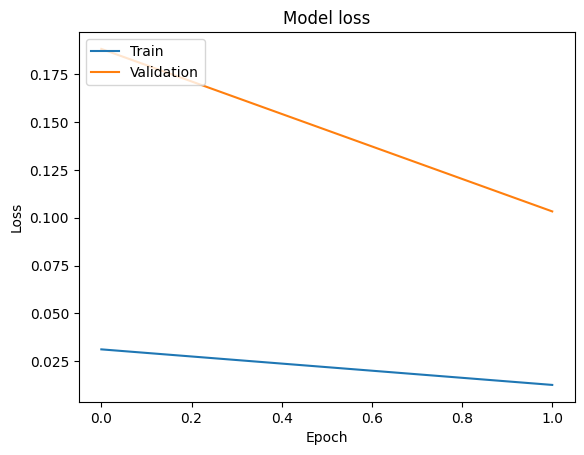

In [16]:
# Plot the metrics to visualize the training process
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_metrics(history)

In [17]:
# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(
    '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test',
    target_size=(139, 139),
    batch_size=batch_size,
    class_mode='categorical'
)

test_labels = test_dataset.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

start_time = time.time()
y_pred = model.predict(test_dataset)
y_pred_bool = np.argmax(y_pred, axis=1)
rounded_labels = np.argmax(test_labels, axis=1)

print(classification_report(y_pred_bool, rounded_labels, digits=4))
print("Time taken to predict the model: " + str(time.time() - start_time))

# Save the model
model.save('plant_disease_model_inception.h5')


Found 118 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       118

    accuracy                         1.0000       118
   macro avg     1.0000    1.0000    1.0000       118
weighted avg     1.0000    1.0000    1.0000       118

Time taken to predict the model: 9.500518321990967


In [20]:
import os
print(os.listdir('/kaggle/working/'))


[]


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model
#model = tf.keras.models.load_model('/kaggle/working')  # Replace 'your_model_directory' with the path to your saved model

# Load and preprocess your image
img_path = '/kaggle/input/weed-detection/test/ridderzuring_3109_jpg.rf.b8e99770acf95370b238f2af2a71f5a3.jpg'  # Replace 'path_to_your_image.jpg' with your image file path
img = image.load_img(img_path, target_size=(139, 139))  # Resize to match the input size of your model


In [23]:
# Load and preprocess your image
img_path = '/kaggle/input/weedcrop-image-dataset/WeedCrop.v1i.yolov5pytorch/test/images/12122_jpg.rf.d7313af9bab0e80b7149ee0a3c32caf8.jpg'  # Replace with the path to your image file
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(139, 139))  # Load the image and resize
img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to array
img_array = tf.image.resize(img_array, (139, 139))  # Resize the image to match the model's input size
img_array = tf.expand_dims(img_array, axis=0)  # Add a batch dimension

# Get the predictions for the image
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [24]:
# Get the predictions for the image
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Generate the heatmap
last_conv_layer = model.get_layer('mixed10')
heatmap_model = tf.keras.models.Model(model.inputs, [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(img_array)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)

heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

# Convert both arrays to the same data type (e.g., unsigned 8-bit integer)
img_array_uint8 = (img_array[0].numpy() * 255).astype(np.uint8)
heatmap_resized_uint8 = (heatmap_resized * 255).astype(np.uint8)  # Adjust the range of heatmap values

# Overlay the heatmap on the original image
heatmap_resized_uint8 = cv2.applyColorMap(heatmap_resized_uint8, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_array_uint8, 0.6, heatmap_resized_uint8, 0.4, 0)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


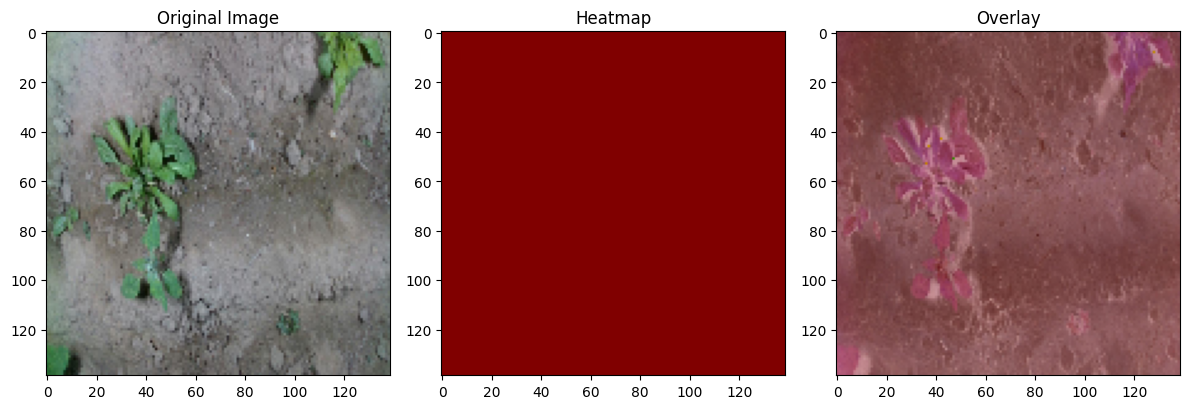

In [25]:
# Display the original image, heatmap, and overlay
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
plt.imshow(heatmap_resized_uint8)
plt.title('Heatmap')

plt.subplot(133)
plt.imshow(superimposed_img)
plt.title('Overlay')

plt.tight_layout()
plt.show()